**IMPORTS**

In [1]:
import pandas as pd
import bz2
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

**DATASETS**

In [2]:
DATA_FOLDER = 'data/'
SPEAKER_ATTRIBUTES_DATA = DATA_FOLDER+"speaker_attributes.parquet"

KNOWN_SPEAKER = DATA_FOLDER+"100000_knownspeakers_2019"
KNOWN_SPEAKER_DATA = KNOWN_SPEAKER+".json.bz2"
RETURN_FILE_DATA = KNOWN_SPEAKER+"_with_attributes.json.bz2"

**DICTIONNARIES**

In [3]:
GENDER_DICT = DATA_FOLDER + "dict_genders.json"

Load the data:

In [4]:
with open(GENDER_DICT) as json_file:
    gender_dict = json.load(json_file)

In [5]:
#Creation of a json file from df_new
df_new = pd.read_json(RETURN_FILE_DATA)

In [6]:
df_new.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,gender,date_of_birth,occupation
0,2019-04-08-048753,It is immoral. It is harmful. It is hurtful.,President Donald Trump,Q22686,2019-04-08 16:22:00,44,"[[President Donald Trump, 0.5802], [None, 0.36...",[https://www.mercedsunstar.com/news/business/a...,E,[Q6581097],[+1946-06-14T00:00:00Z],"[Q911554, Q557880, Q3427922, Q15980158, Q13152..."
1,2019-05-26-025817,It is where they want to be and where they sho...,President Donald Trump,Q22686,2019-05-26 15:37:49,3,"[[President Donald Trump, 0.6408], [None, 0.35...",[http://www.breitbart.com/news/trump-vows-roll...,E,[Q6581097],[+1946-06-14T00:00:00Z],"[Q911554, Q557880, Q3427922, Q15980158, Q13152..."
2,2019-03-20-001438,"a horrible, disgraceful thing and a horrible act.",President Donald Trump,Q22686,2019-03-20 16:36:57,5,"[[President Donald Trump, 0.871], [None, 0.129]]",[https://www.factcheck.org/2019/03/the-facts-o...,E,[Q6581097],[+1946-06-14T00:00:00Z],"[Q911554, Q557880, Q3427922, Q15980158, Q13152..."
3,2019-03-29-004685,Allies expressed their support for the secreta...,President Donald Trump,Q22686,2019-03-29 00:25:02,2,"[[President Donald Trump, 0.6996], [None, 0.23...",[https://www.brecorder.com/2019/03/29/484053/n...,E,[Q6581097],[+1946-06-14T00:00:00Z],"[Q911554, Q557880, Q3427922, Q15980158, Q13152..."
4,2019-07-23-003672,"And if I can help, I would love to be a mediator.",Donald Trump,Q22686,2019-07-23 14:52:24,1,"[[Donald Trump, 0.8156], [None, 0.1516], [Imra...",[http://vanityfair.com/news/2019/07/trump-modi...,E,[Q6581097],[+1946-06-14T00:00:00Z],"[Q911554, Q557880, Q3427922, Q15980158, Q13152..."


In [7]:
#Drop rows with None as gender
df_new.dropna(axis = 0, subset = ['gender'], inplace = True)

In [8]:
#Check if it has removed rows: it does
df_new.shape[0]

98277

In [9]:
#Keep only the first gender in the list 
df_new['gender'] = df_new['gender'].apply(lambda x: x[0])

In [10]:
#only keeping the first probability corresponding to the speaker with the highest proba, associated as the speaker for the quotation.
df_new['probas']= df_new['probas'].apply(lambda x: x[0][1])

#convert this probability in a float number
df_new['probas']= df_new['probas'].apply(lambda x: float(x))

#drop the lines where the probability is lower than 0.7, considered as uncertainities.
df_new = df_new.drop(df_new[df_new.probas < 0.7].index)
df_new.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,gender,date_of_birth,occupation
2,2019-03-20-001438,"a horrible, disgraceful thing and a horrible act.",President Donald Trump,Q22686,2019-03-20 16:36:57,5,0.8710,[https://www.factcheck.org/2019/03/the-facts-o...,E,Q6581097,[+1946-06-14T00:00:00Z],"[Q911554, Q557880, Q3427922, Q15980158, Q13152..."
4,2019-07-23-003672,"And if I can help, I would love to be a mediator.",Donald Trump,Q22686,2019-07-23 14:52:24,1,0.8156,[http://vanityfair.com/news/2019/07/trump-modi...,E,Q6581097,[+1946-06-14T00:00:00Z],"[Q911554, Q557880, Q3427922, Q15980158, Q13152..."
6,2019-05-17-058726,It's probably more posturing but they will com...,President Donald Trump,Q22686,2019-05-17 03:35:00,1,0.8886,[http://ctvnews.ca/business/north-american-mar...,E,Q6581097,[+1946-06-14T00:00:00Z],"[Q911554, Q557880, Q3427922, Q15980158, Q13152..."
8,2019-02-15-009152,Asylum seekers in Mexico face a heightened ris...,President Donald Trump,Q22686,2019-02-15 03:20:00,5,0.7752,[http://www.abajournal.com/news/article/lawsui...,E,Q6581097,[+1946-06-14T00:00:00Z],"[Q911554, Q557880, Q3427922, Q15980158, Q13152..."
10,2019-01-28-054567,lack of support for and trust of American inte...,President Trump,Q22686,2019-01-28 20:39:06,1,0.8554,[https://www.theepochtimes.com/skepticism-of-t...,E,Q6581097,[+1946-06-14T00:00:00Z],"[Q911554, Q557880, Q3427922, Q15980158, Q13152..."


In [11]:
#Group the data by gender
speaker_grouped = df_new.groupby(df_new.gender)

In [12]:
#Keep only the 2 most represented gender and group the other in "others"
major_gender = speaker_grouped.speaker.count().sort_values(ascending = False)[0:2]
others = speaker_grouped.speaker.count().sort_values(ascending = False)[2:]


In [13]:
#Create a new serie for the barplot
other_group = pd.Series([others.values.sum()], index=['Others'])
major_gender_and_others = major_gender.append(other_group)

In [14]:
major_gender_and_others

Q6581097    55934
Q6581072    12193
Others        116
dtype: int64

##TODO: try to label with 'Male' and 'Female' (il fait wtf la il devrait les mettre je comprends pas ce qu'il fout...) 

In [32]:
#Barplot to see how many quotations attributed to each gender
#sns.set(rc = {'figure.figsize':(10,4)})
#sns.set_palette('colorblind')
#ax = sns.barplot(x = major_gender_and_others.index, y = major_gender_and_others.values, data=major_gender_and_others)
#ax.set_xticklabels(major_gender_and_others.index);
#ax.set_yscale("log")
#plt.title('Number of citations by gender');
#plt.ylabel('Number of citations');
#plt.xlabel('Gender');

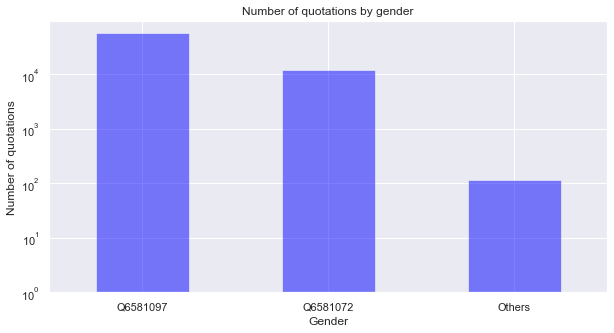

In [48]:
pl = major_gender_and_others.plot(kind="bar", x=major_gender_and_others.index, y=major_gender_and_others.values, figsize=(10, 5), log=True, \
                        alpha=0.5, rot=0, color="blue")
pl.set_xlabel("Gender")
pl.set_ylabel("Number of quotations")
pl.set_title("Number of quotations by gender");

**Be careful, this plot has log scale in y-axis.**


We see that there is only a few citations linked to speaker with gender other than 'male' or 'female'. For this reason, we will focus only on male and female gender, in order to examine the differences between them.

In [16]:
#Drop the rows having a gender other than the 2 most represented
df_MF = df_new.drop(df_new[
        df_new['gender'].isin(major_gender.index) == False].index, inplace = False)

In [17]:
df_new.shape[0]

68243

In [18]:
#Replace the code by the item 'male' or 'female' thanks to the dictionnary
df_MF['gender'] = [gender_dict[x] for x in df_MF.gender.to_list()]

In [19]:
#Group again by gender, now that only 2 groups remains
gender_groups = df_MF.groupby(df_MF.gender)

In [20]:
#Count the number of occurences by gender (quotations*occurences)
citations_by_gender = gender_groups.numOccurrences.sum().sort_values(ascending = False)
citations_by_gender

gender
male      185378
female     39008
Name: numOccurrences, dtype: int64

In [35]:
#Barplot representing the number of occurences by gender 
#ax = sns.barplot(x = citations_by_gender.index, y = citations_by_gender.values, data=citations_by_gender)
#plt.title('Number of occurences by gender');
#plt.ylabel('Number of occurences');
#plt.xlabel('Gender');

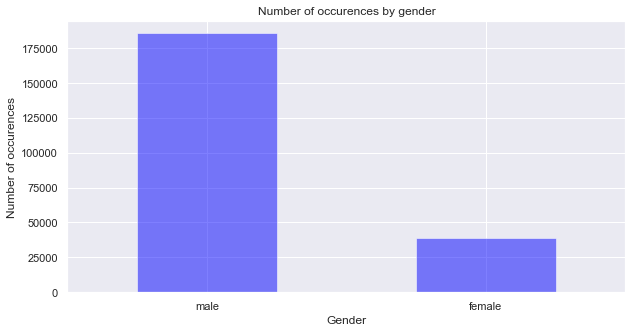

In [47]:
pl = citations_by_gender.plot(kind="bar", x=citations_by_gender.index, y=citations_by_gender.values, figsize=(10, 5), log=False, \
                        alpha=0.5, rot=0,color="blue")
pl.set_xlabel("Gender")
pl.set_ylabel("Number of occurences")
pl.set_title('Number of occurences by gender');

In [22]:
#GroupBy qids in order to get unique speakers. We add gender in the groupBy, but since we already assigned one 
#gender per speaker, it is just to provide the information in the indexing. 
unique_speaker = df_MF.groupby(['qids','gender']).mean()

In [23]:
#Let's check that the speakers are unique. 
unique_speaker.index.is_unique

True

In [24]:
print('There are', speaker_grouped.ngroups, 'unique speakers in this dataset.')

There are 11 unique speakers in this dataset.


In [25]:
#Extract the list of genders among the unique speakers
unique_speaker_gender = unique_speaker.index.to_list()

In [26]:
#Count the number of male speakers, and the number of female speakers
speaker_HF = Counter([x[1] for x in unique_speaker_gender])

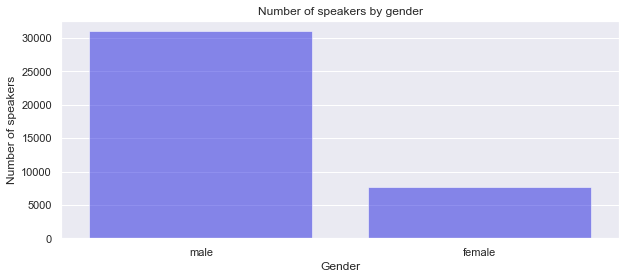

In [46]:
ax = sns.barplot(x=list(speaker_HF.keys()), y=list(speaker_HF.values()),alpha=0.5,color="blue")
plt.title('Number of speakers by gender');
plt.ylabel('Number of speakers');
plt.xlabel('Gender');